# Ray Tracing in One Weekend

[Ray Tracing in One Weekend](https://raytracing.github.io/books/RayTracingInOneWeekend.html) in a Julia Notebook.

# Displaying Images

In [1]:
using Images

In [2]:
(image_width, image_height) = (256, 256)

(256, 256)

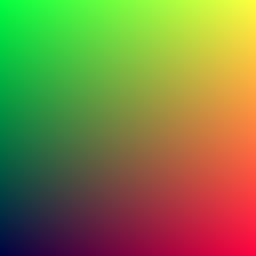

In [3]:
[RGB(i / image_width, j / image_height, 0.25) for j in image_height:-1:1, i in 1:image_width]